In [1]:
import time 
import numpy as np
import matplotlib 
import matplotlib.pyplot  as plt
from pathlib import Path

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, RandomSampler
import torchinfo

### Own modules
import sys
sys.path.insert(0, '../src/')

from PDE import Poisson1D
from PINN import PINN
from plotFunctions import plot_NTK, plot_param_ntk_diff, plot_NTK_change, plot_convergence_rate
from NTK_helper import compute_convergence_rate

### Set dtype and device to be used
dtype = torch.float32

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')


save_model      = False
train_model     = True
model_name      = 'Poisson1D'


### 1D Poisson

\begin{align}
u_{xx} &= f(x), \hspace{1.3cm} x \in \Omega \\
u(x) &= g(x), \hspace{1.3cm} x \in \partial \Omega
\end{align}

Where: 

\begin{align}
    f(x) &= -a^{2}\pi^{2}\sin(a\pi x), \hspace{0.2cm} x \in [0,1] \\
    g(x) &= 0, \hspace{2.3cm} x = 0,1
\end{align}

##### Define exact, source and boundary condition functions

In [2]:
##### Define Poisson1D exact, source and boundary condition functions
def f_u_exact(a,x):
    """ 
    Exact solution
    """
    u_exact = torch.sin(a*torch.pi*x)

    return u_exact

def f_x(a, x):
    """
    Source/Forcing function
    """
    fx = -(a**2)*(torch.pi**2)*torch.sin(a*torch.pi*x)
       
    return fx

def g_x(x, xb):
    """
    Boundary condition
    """
    
    ub = torch.zeros(x.size(), dtype=dtype)

    xb1_idx = torch.where(x == xb[0])[0]
    xb2_idx = torch.where(x == xb[1])[0]

    ub[xb1_idx] = 0
    ub[xb2_idx] = 0

    return ub

#### Setup data

In [3]:
# Define PDE domain
X_0,X_N = 0.,1.
X_bc  = [X_0, X_N]

# Number of points
NX  = 100
dx = (X_N - X_0) / NX

# Create points for interior and boundary
Xr = torch.linspace(X_0, X_N, NX, dtype=dtype, device=device, requires_grad=True).view(-1,1)
Xb = torch.randint(0, 2, (NX,1),  dtype=dtype, device=device, requires_grad=True)
X  = torch.hstack((Xr, Xb))

# Setup dataset
Br      = 100
Bb      = 100
rand_sampler = RandomSampler(X, replacement=True)
XTrain       = DataLoader(X, batch_size=Br, shuffle=True)
training_batches = len(XTrain)

print(f"Training batch XTrain: {training_batches}")

Training batch XTrain: 1


### Setup network training parameters

In [5]:
# Settings
# NTK computation settings
compute_NTK          = True
compute_NTK_interval = 10

# Logging parameters
log_parameters     = True
log_NTK            = True

# Adapation algorithm
use_adaptation_algorithm = True

# correct for coupled parameters
if not compute_NTK:
    log_NTK = False
    use_adaptation_algorithm = False    

# net parameters
input_size  = 1
output_size = 1

# Training parameters
learning_rate = 1e-5
epochs        = int(100)

## Result 1

Compute initial NTK estimation



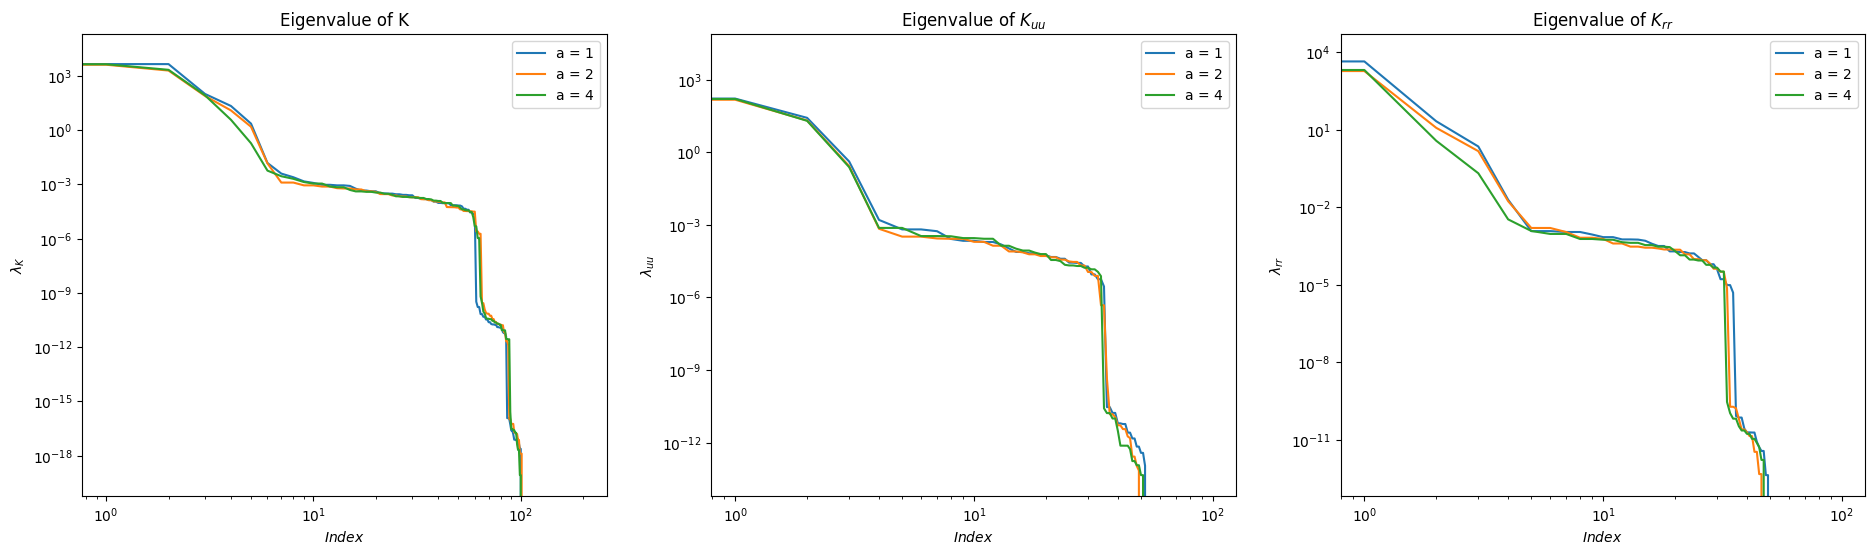

In [6]:

### Setup PDE Equation
a   = [1, 2, 4]
PDE = [Poisson1D(a_i) for a_i in a]

# network neurons
neurons     = [100]
neural_nets =  [PINN(input_size, output_size, neurons, PDE_i, 'normal', dtype, device, log_parameters, log_NTK).to(device) for PDE_i in PDE]; 

data_labels = [f'a = {a_i}' for a_i in a]
ylabels1    = [r'$\lambda_{K}$', r'$\lambda_{uu}$', r'$\lambda_{rr}$']

# Plot 1 - initial NTK
fig0, axs0 = plt.subplots(1,3, figsize=(23,6))

x       = next(iter(XTrain)).view(-1, Br, 1)
x_prime = next(iter(XTrain)).view(-1, Br, 1)

print("Compute initial NTK estimation\n")
for net in neural_nets:
    ## Observe initial estimation of NTK Matrix
    net.eval()
    net.NTK(x, x_prime)

    if log_NTK:
        net.log_NTK(0)
        plot_NTK(net, fig0, axs0)

for i, ax in enumerate(axs0):
    ax.legend(labels=data_labels)
    # ax.ticklabel_format(axis='y', scilimits=(0,0))
    ax.set_yscale('log')
    ax.set_ylabel(ylabels1[i])
    ax.set_xlabel(r'$Index$')

plt.show()


In [7]:

##### Train network
optimizer = optim.SGD
# optimizer = optim.Adam

optimizers = [optimizer(net_i.parameters(), learning_rate) for net_i in neural_nets]

# Auto Mixed Precision settings
use_amp = False
if device == torch.device('cpu'):
    print("Using CPU")
    use_amp = False

# use scaler
scaler  = torch.cuda.amp.GradScaler(enabled=use_amp)

### Model save settings
if use_adaptation_algorithm and compute_NTK:
    model_adaption = '_adapted'
else:
    model_adaption = ''

if isinstance(optimizers[0], optim.SGD):
    opt = 'SGD'
elif isinstance(optimizers[0] , optim.Adam):
    opt = 'Adam'

file_name = f'{model_name}_Epoch={epochs}_Optimizer={opt}{model_adaption}'
path      = './results/models/'
pathfile  = path+file_name+"_freqAmplitude"
Path(path).mkdir(parents=True, exist_ok=True)

In [8]:
#### Train loop
def train_network(a, net, optimizer):

    train_losses = []
    for epoch in range(epochs+1):

        if epoch == 0 and compute_NTK:
            ## Observe initial estimation of NTK Matrix
            net.eval()
            x       = next(iter(XTrain)).view(-1, Br, 1)
            x_prime = next(iter(XTrain)).view(-1, Br, 1)

            net.NTK(x, x_prime)
            if log_NTK:
                net.log_NTK(0)
            # reset lambda
            # net.lambda_adaptation = torch.tensor([1., 1.], dtype=dtype, device=device)

        # log parameters and set in training mode
        net.log_parameters(epoch)
        net.train()

        epoch_loss   = 0.0

        for i, x in enumerate(XTrain):
            # reset gradients
            optimizer.zero_grad()

            xr = x[:,0].view(-1,1).to(device); xb = x[:,1].view(-1,1).to(device)

            x = torch.stack([xr, xb], dim=0)

            ### INTERIOR DOMAIN
            # make prediction w.r.t. interior points

            with torch.autocast(device_type='cuda', dtype=torch.float16, enabled=use_amp):

                ### Predict interior points
                u_hat_x   = net(xr)
            
                # determine gradients w.r.t interior points
                U_x       =  net.compute_pde_gradient(u_hat_x, xr)

                ### BOUNDARY DOMAIN
                u_hat_xb    = net(xb)

                # determine gradients w.r.t boundary points
                U_xb       =  net.compute_pde_gradient(u_hat_xb, xb)
                
                # Compute forcing/source function
                fx = f_x(a, xr).T.to(device)

                # compute boundary condition
                gx = g_x(xb, X_bc).T.to(device)

                # Stack
                U = torch.stack((U_x, U_xb), dim=0)

                ## Backward step
                net.backward(x, U, fx, gx, use_adaption=use_adaptation_algorithm)
                epoch_loss += net.loss.item()
                if i == len(XTrain) - 1:
                    x_prime  = x

            # Do optimisation step
            if use_amp:
                scaler.scale(net.loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                net.loss.backward()
                optimizer.step()

        ### END Batch loop

        # Compute NTK
        if epoch > 0:
            if (epoch % compute_NTK_interval == 0 or epoch == epochs - 1) and compute_NTK:

                net.eval()
                net.NTK(x, x_prime)

                if log_NTK:
                    net.log_NTK(epoch)

        train_losses.append(epoch_loss / len(XTrain))
        
        if epoch % 100 == 0 or epoch == epochs: 
            print(f"Epoch: {epoch:4d}     Loss: {train_losses[-1]:4f}   Lr: {optimizer.param_groups[0]['lr']:.2E}")

            if use_adaptation_algorithm:
                lambda_weights = ""
                for lambda_i in net.lambda_adaptation:
                    lambda_weights += f"{lambda_i.item():5f} "
                print(f"                Lambda Adaption: " + lambda_weights)
    ### END training loop

    #### save model
    if save_model:
        net.save_model(pathfile)
        net.save_log(pathfile)
        with open(f'{pathfile}.npy', 'wb') as f:
            np.save(f, np.array(train_losses))

    return net, train_losses

In [9]:
# RUN NETWORK
train_losses = []
for a_i, net, optimizer in zip(a,neural_nets, optimizers):
    print("TRAIN NETWORK:", f"a = {a_i}")
    net, losses = train_network(a_i, net, optimizer)

TRAIN NETWORK: a = 1
Epoch:    0     Loss: 436.481506   Lr: 1.00E-05
                Lambda Adaption: 1.991576 2.008495 
Epoch:  100     Loss: 90.956993   Lr: 1.00E-05
                Lambda Adaption: 1.265430 4.767464 
TRAIN NETWORK: a = 2
Epoch:    0     Loss: 1525.589355   Lr: 1.00E-05
                Lambda Adaption: 1.801365 2.247871 
Epoch:  100     Loss: 727.860352   Lr: 1.00E-05
                Lambda Adaption: 1.341386 3.929232 
TRAIN NETWORK: a = 4
Epoch:    0     Loss: 23571.792969   Lr: 1.00E-05
                Lambda Adaption: 1.917869 2.089481 
Epoch:  100     Loss: 16085.925781   Lr: 1.00E-05
                Lambda Adaption: 1.362248 3.760543 


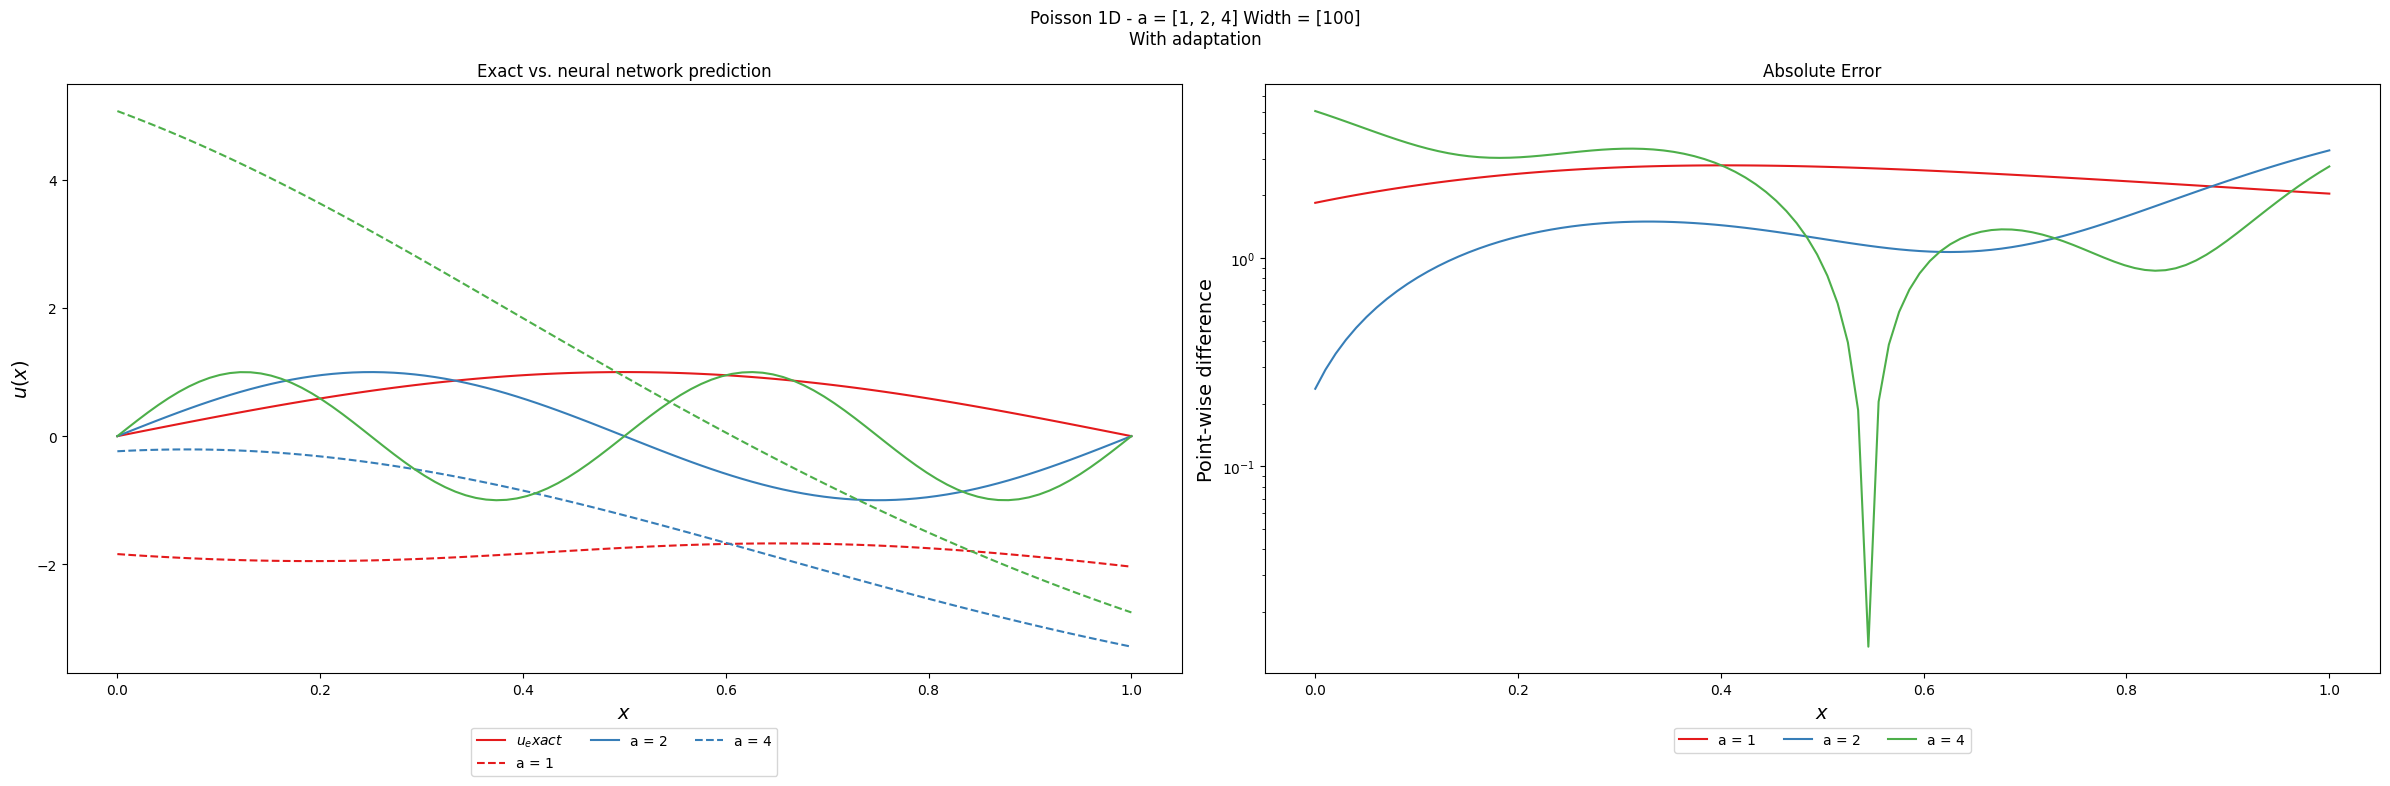

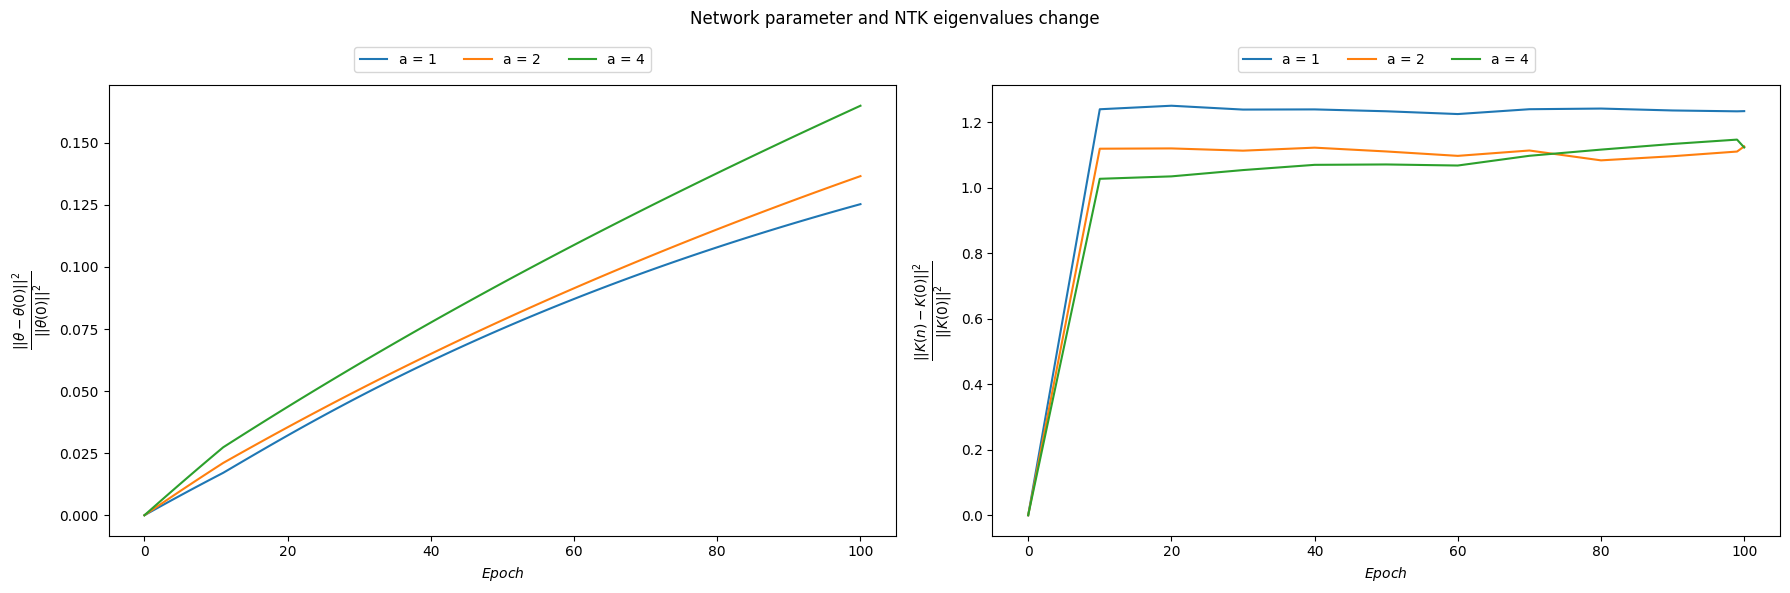

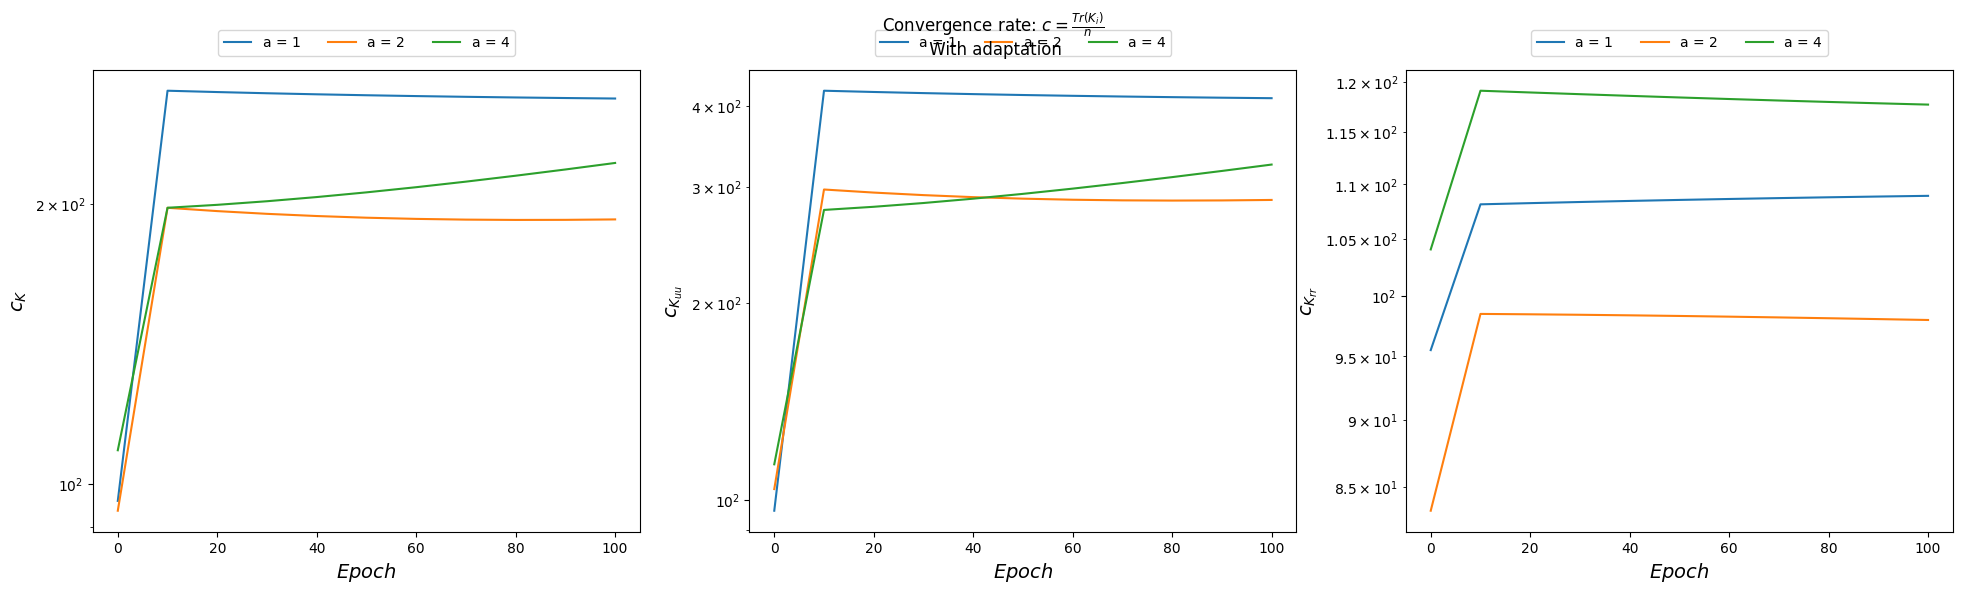

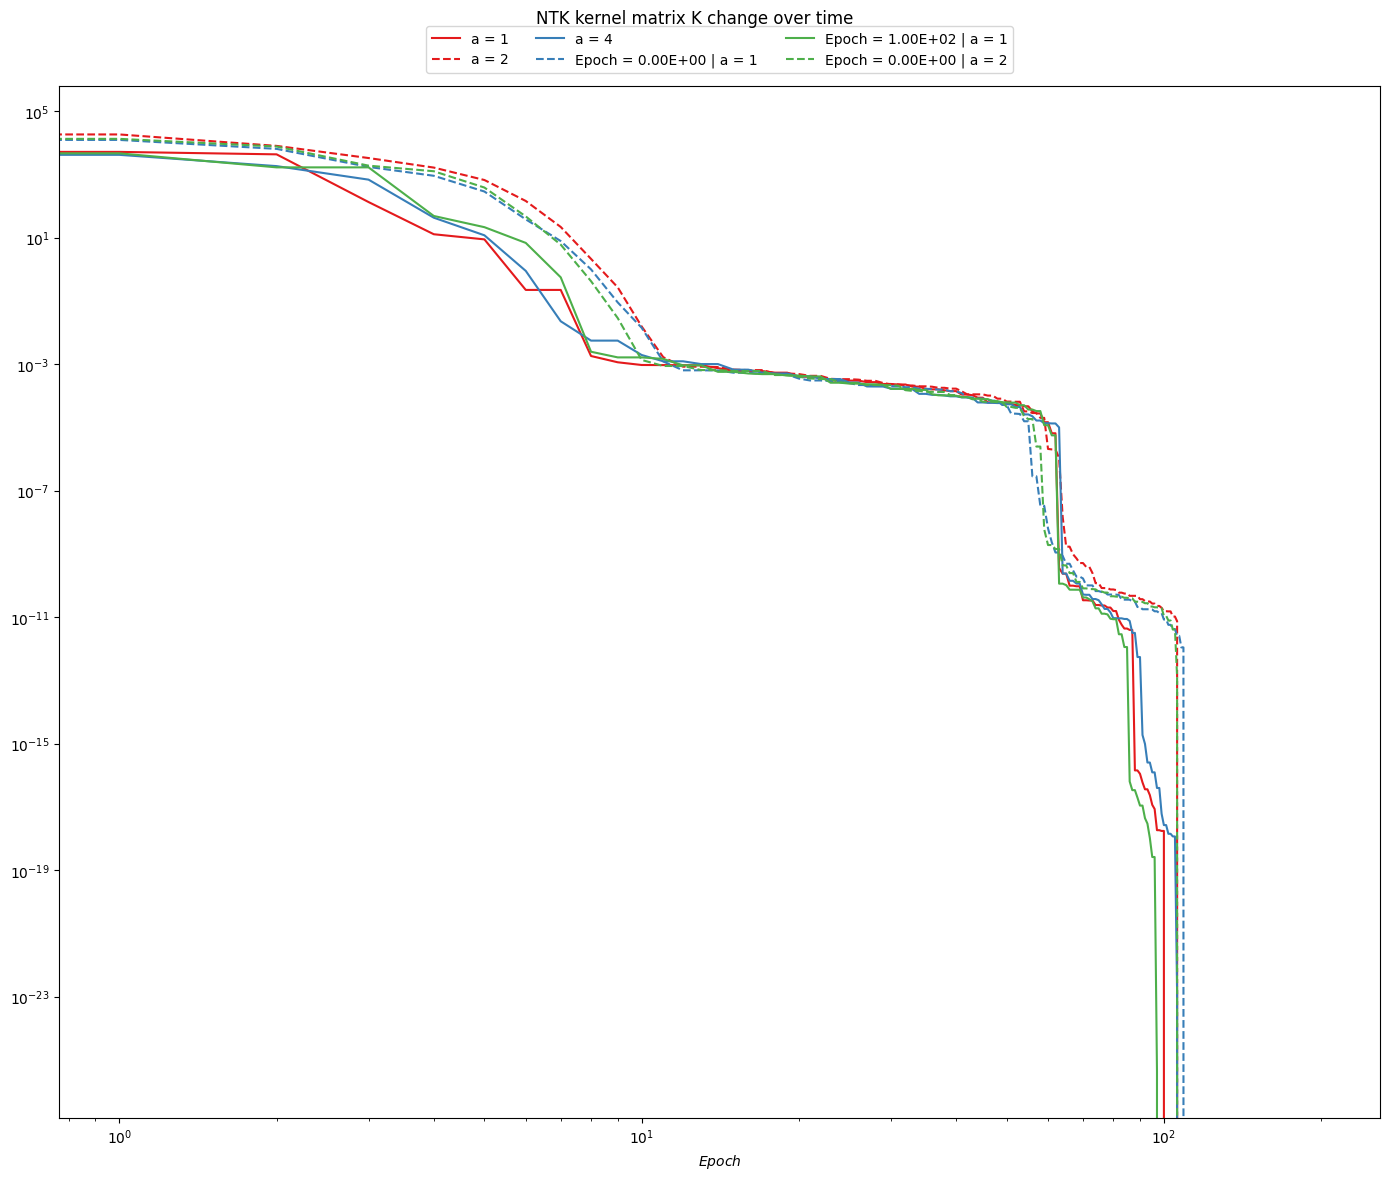

In [10]:
########### PLOT RESULTS

path      = './results/figures/'
pathfile  = path+file_name+"_neurons"
Path(path).mkdir(parents=True, exist_ok=True)


NX = 100
x  = torch.linspace(X_0, X_N, NX, dtype=dtype).view(-1,1).to(device)

# Plot 1 - solution and train losses
fig1 = plt.figure(figsize=(24,8))
gs   = fig1.add_gridspec(1,2)
cm   = matplotlib.cm.Set1

# ax1
ax0 = fig1.add_subplot(gs[0,0])
ax0.set_title('Exact vs. neural network prediction')
ax0.set_ylabel(r'$u(x)$', size=14)
ax0.set_xlabel(r'$x$', size=14)

# ax2
ax1 = fig1.add_subplot(gs[0,1])
ax1.set_title('Absolute Error')
ax1.set_ylabel('Point-wise difference', size=14)
ax1.set_xlabel(r'$x$', size=14)

for i, net in enumerate(neural_nets):
    net.eval()

    u_exact = f_u_exact(a[i], x)
    u_pred  = net(x)

    xplot   = x.cpu().detach().numpy()
    u_exact = u_exact.cpu().detach().numpy()
    u_pred  = u_pred.cpu().detach().numpy()

    # Plot 1 - predict 
    ax0.plot(xplot, u_exact,      color=cm(i),  label=r'$u_{exact}$ | a = ' + str(a[i]))
    ax0.plot(xplot, u_pred, '--', color=cm(i),  label=r'$u_{pred}$  | a = ' + str(a[i]))

    # Plot 2 - error plot
    pointWise_err = np.abs(u_exact - u_pred)
    ax1.semilogy(xplot, pointWise_err, color=cm(i), label= data_labels[i])

ax0.legend(labels=[f'$u_exact$', *data_labels], loc='upper center', bbox_to_anchor=(0.5, -0.08), fancybox=True, ncol=3)
ax1.legend(labels=data_labels, loc='upper center', bbox_to_anchor=(0.5, -0.08), fancybox=True, ncol=3)

if use_adaptation_algorithm:
    fig1.suptitle(f'Poisson 1D - a = {a} Width = {neurons}\nWith adaptation')
else:
    fig1.suptitle(f'Poisson 1D - a = {a} Width = {neurons}')

fig1.tight_layout()
fig1.savefig(pathfile+'_plot_1D', bbox_inches='tight',)

# Plot 2 - Parameter and ntk difference
fig2, axs2 = plt.subplots(1,2, figsize=(18,6))

for net in neural_nets:
    fig2, axs2 = plot_param_ntk_diff(net, fig2, axs2)
for ax in axs2:
    ax.legend(labels=data_labels, loc='upper center', bbox_to_anchor=(0.5, 1.1),
          fancybox=True, ncol=3)
fig2.tight_layout()
fig2.savefig(pathfile+'_plot_param_ntk_diff', bbox_inches='tight',)

# Plot 3 - Convergence rate for all matrices
fig3, axs3 = plt.subplots(1,3, figsize=(24,6))
if use_adaptation_algorithm:
    fig3.suptitle('Convergence rate: ' + r'$c = $' + r'$\frac{Tr(K_{i})}{n}$' +'\n With adaptation')
else:
    fig3.suptitle('Convergence rate: ' + r'$c = $' + r'$\frac{Tr(K_{i})}{n}$')

ylabels = [r'$c_{K}$', r'$c_{K_{uu}}$', r'$c_{K_{rr}}$', r'$c_{K_{ii}}$']

for i,net in enumerate(neural_nets):
    NTK_epochs, NTK_convergenceRate = compute_convergence_rate(net)
    NTK_convergenceRate  = np.real(NTK_convergenceRate.detach().cpu().numpy())
    n = NTK_convergenceRate.shape[1]

    for j in range(n):
        axs3[j].semilogy(NTK_epochs, NTK_convergenceRate[:,j]); 

for i,ax in enumerate(axs3):
    ax.set_xlabel(r'$Epoch$', size=14)
    ax.set_ylabel(ylabels[i], size=14)
    ax.legend(labels=data_labels, loc='upper center', bbox_to_anchor=(0.5, 1.1),
          fancybox=True, ncol=3)

fig3.savefig(pathfile+'_plot_convergence_rate', bbox_inches='tight',)

# Plot 4 - NTK change
fig4, axs4 = plt.subplots(1,1, figsize=(14,12))
for i,net in enumerate(neural_nets):
    plot_NTK_change(net, fig4, axs4, cm(i))

for a_i in a:
    data_labels.append(f'Epoch = {0:.2E} | a = {a_i}')
    data_labels.append(f'Epoch = {epochs:.2E} | a = {a_i}')
axs4.legend(labels=data_labels, loc='upper center', bbox_to_anchor=(0.5, 1.065),
        fancybox=True, ncol=3)

fig4.tight_layout()
fig4.savefig(pathfile+'_plot_NTK_change', bbox_inches='tight')

plt.show()

## Result 2

### Setup PINN 

In [ ]:
neurons = [[10], [100], [500]]
a       = 4
PDE     = Poisson1D(a)

neural_nets  = [PINN(input_size, output_size, neurons_i, PDE, 'normal', dtype, device, log_parameters, log_NTK) for neurons_i in neurons]

X       = next(iter(XTrain))
X_prime = next(iter(XTrain))

xr       = X[:,0].to(device).view(-1,1);       xb       = X[:,1].to(device).view(-1,1)
xr_prime = X_prime[:,0].to(device).view(-1,1); xb_prime = X_prime[:,1].to(device).view(-1,1)

x = torch.stack([xr, xb], dim=0);      x_prime = torch.stack([xr_prime, xb_prime], dim=0)

for net in neural_nets:
    net.to(device)
    net.NTK(x, x_prime)
    net.log_NTK(0)

### PLOT Eigenvalue of NTK matrices for different widths
fig, axs = plt.subplots(1,3, figsize=(23,6))
data_labels = [f'width = {neuron_i}' for neuron_i in neurons]
ylabels = [r'$\lambda_{K}$', r'$\lambda_{uu}$', r'$\lambda_{rr}$']

for net in neural_nets:
    plot_NTK(net, fig, axs)

for i,ax in enumerate(axs):
    ax.legend(labels=data_labels)
    # ax.ticklabel_format(axis='y', scilimits=(0,0))
    ax.set_yscale('log')
    ax.set_ylabel(ylabels[i], size=14)
    ax.set_xlabel(r'$Index$', size=14)

plt.tight_layout()
plt.show()

In [ ]:
optimizer = optim.SGD
# optimizer = optim.Adam

optimizers = [optimizer(net_i.parameters(), learning_rate) for net_i in neural_nets]

for neurons_i, net, optimizer in zip(neurons, neural_nets, optimizers):
    print("TRAIN NETWORK:", f"neurons = {neurons_i}")

    net = train_network(a, net, optimizer)

#### Result plot

In [ ]:
########### PLOT RESULTS

path      = './results/figures/'
pathfile  = path+file_name+"_width"
Path(path).mkdir(parents=True, exist_ok=True)

NX = 100
x = torch.linspace(X_0, X_N, NX, dtype=dtype).view(-1,1).to(device)

fig1 = plt.figure(1, (24,8), layout='tight')
gs  = fig1.add_gridspec(1,2)
cm = matplotlib.cm.Set1

# ax1
ax0 = fig1.add_subplot(gs[0,0])
ax0.set_title('Exact vs. neural network prediction')
ax0.set_ylabel(r'$u(x)$', size=14)
ax0.set_xlabel(r'$x$', size=14)

# ax2
ax1 = fig1.add_subplot(gs[0,1])
ax1.set_title('Absolute Error')
ax1.set_ylabel('Point-wise difference', size=14)
ax1.set_xlabel(r'$x$', size=14)

u_exact = f_u_exact(a, x)
xplot   = x.cpu().detach().numpy()
u_exact = u_exact.cpu().detach().numpy()
ax0.plot(xplot, u_exact, color=cm(0),  label=r'$u_{exact}$')

for i, net in enumerate(neural_nets):
    net.eval()
    u_pred  = net(x)

    u_pred  = u_pred.cpu().detach().numpy()

    # Plot 1 - predict 
    ax0.plot(xplot, u_pred, '--', color=cm(i+1),  label=r'$u_{pred}$  | width = ' + str(neurons[i]))
    # Plot 2 - error plot
    pointWise_err = np.abs(u_exact - u_pred)
    ax1.semilogy(xplot, pointWise_err, color=cm(i+1), label= data_labels[i])

ax0.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08), fancybox=True, ncol=4)
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08), fancybox=True, ncol=3)


if use_adaptation_algorithm:
    fig1.suptitle(f'Poisson 1D - a = {a} Width = {neurons}\nWith adaptation')
else:
    fig1.suptitle(f'Poisson 1D - a = {a} Width = {neurons}')

fig1.tight_layout()
fig1.savefig(pathfile+'_plot_1D', bbox_inches='tight',)

# Plot 2 - Parameter and ntk difference
fig2, axs2 = plt.subplots(1,2, figsize=(18,6))

for net in neural_nets:
    fig2, axs2 = plot_param_ntk_diff(net, fig2, axs2)
for ax in axs2:
    ax.legend(labels=data_labels, loc='upper center', bbox_to_anchor=(0.5, 1.1),
          fancybox=True, ncol=3)

fig2.tight_layout()
fig2.savefig(pathfile+'_plot_param_ntk_diff', bbox_inches='tight',)

# Plot 3 - convergence rate for all matrices
fig3, axs3 = plt.subplots(1,3, figsize=(18,6))
if use_adaptation_algorithm:
    fig3.suptitle('Convergence rate: ' + r'$c = $' + r'$\frac{Tr(K_{i})}{n}$' +'\n With adaptation')
else:
    fig3.suptitle('Convergence rate: ' + r'$c = $' + r'$\frac{Tr(K_{i})}{n}$')

ylabels = [r'$c_{K}$', r'$c_{K_{uu}}$', r'$c_{K_{rr}}$', r'$c_{K_{ii}}$']

for i,net in enumerate(neural_nets):
    NTK_epochs, NTK_convergenceRate = compute_convergence_rate(net)
    NTK_convergenceRate  = np.real(NTK_convergenceRate.detach().cpu().numpy())
    n = NTK_convergenceRate.shape[1]

    for j in range(n):
        axs3[j].semilogy(NTK_epochs, NTK_convergenceRate[:,j]); 

for i,ax in enumerate(axs3):
    ax.set_xlabel(r'$Epoch$', size=14)
    ax.set_ylabel(ylabels[i],size=14)
    ax.legend(labels=data_labels, loc='upper center', bbox_to_anchor=(0.5, 1.1),
          fancybox=True, ncol=3)

fig3.tight_layout()
fig3.savefig(pathfile+'_plot_convergence_rate', bbox_inches='tight',)

# Plot 4 - NTK change
fig4, axs4 = plt.subplots(1,1, figsize=(14,12))
for i,net in enumerate(neural_nets):
    plot_NTK_change(net, fig4, axs4, cm(i))

data_labels = []
for neurons_i in neurons:
    data_labels.append(f'Epoch = {0:.0E} | width = {neurons_i}')
    data_labels.append(f'Epoch = {epochs:.0E} | width = {neurons_i}')
axs4.legend(labels=data_labels, loc='upper center', bbox_to_anchor=(0.5, 1.065),
        fancybox=True, ncol=3)

fig4.tight_layout()
fig4.savefig(pathfile+'_plot_NTK_change', bbox_inches='tight',)

plt.show()